In [1]:
import os, json

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import io
import requests

import csv
import cv2

## Define all paths

In [2]:
img_path = 'https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/combined/%d.jpg'
sketch_path = 'https://storage.googleapis.com/crowdstf-rico-uiuc-4540/swire_dataset_v0.1/sketches/%s.jpg'

sketch_npy_path = 'https://storage.googleapis.com/crowdstf-rico-uiuc-4540/swire_dataset_v0.1/vecs/sketch_vecs_2.npy'
real_npy_path = 'https://storage.googleapis.com/crowdstf-rico-uiuc-4540/swire_dataset_v0.1/vecs/real_vecs_2.npy'

sketch_seg_npy_path = 'https://storage.googleapis.com/crowdstf-rico-uiuc-4540/swire_dataset_v0.1/vecs/sketch_vecs_seg.npy'
real_seg_npy_path = 'https://storage.googleapis.com/crowdstf-rico-uiuc-4540/swire_dataset_v0.1/vecs/real_vecs_seg.npy'

## Image drawing functions

In [3]:
def draw_image(arr, start_fig):
  if start_fig:
    plt.figure(figsize=(35, 35))
    plt.grid(True)
  plt.axis('off')
  # plt.xlim((-limw, arr.shape[1] + limw))
  # plt.ylim((arr.shape[0] + limw, -limw))
  plt.imshow(arr, interpolation='bilinear')
  if start_fig:
    plt.show()

def draw_real_image(ui_id, draw_subfig=False):
  arr = io.imread(img_path % ui_id)
  draw_image(arr, start_fig=not draw_subfig)
  
def draw_actual_sketch(sketch_name, draw_subfig=False, crop=False):
  arr = io.imread(sketch_path % sketch_name)
  arr = np.array(arr).astype(np.uint8)
  if len(arr.shape) > 2 and arr.shape[-1] > 1:
    arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
  arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
  arr = np.clip(255 - arr, 0, 255)
  seg_height = arr.shape[0] // 3 
  if crop:
    arr = arr[seg_height * 2: seg_height * 3]
  draw_image(arr, start_fig=not draw_subfig)
    

In [4]:
def load_remote_npy(npy_path):
    res = requests.get(npy_path)
    f = open('tmp.npy', 'wb')
    f.write(res.content)
    f.close()
    return np.load('tmp.npy')

## Querying closest screenshots

In [5]:
def search_best_from_vecs(sketch_vecs, real_vecs):
  top_res = []
  for sv in sketch_vecs:
    nn = real_vecs[np.argsort(np.array([np.linalg.norm(sv[0]-x[0])
                                        for x in real_vecs]))[:10]]
    if sv[1] == nn[0, 1]:
      top_res.append((sv[1], nn[:, 1]))

  return top_res

def search_results_from_vecs(sketch_vecs, real_vecs):
  res = []
  for sv in sketch_vecs:
    nn = real_vecs[np.argsort(np.array([np.linalg.norm(sv[0]-x[0])
                                        for x in real_vecs]))]
    id_ranks = [nn[i, 1] for i in range(nn.shape[0])]
    res.append((sv[1], nn[:, 1], id_ranks.index(sv[1])))
  
  res = sorted(res, key=lambda x: x[2])
  print(max(res, key=lambda x: x[2]))
  return res
  

def print_query_results(res, figsize=(35, 35)):
  plt.figure(figsize=figsize)
  plt.subplot(1, 11, 1)
  draw_actual_sketch(str(res[0]) + '_4', figsize is not None)
  # draw_real_image(res[0], figsize is not None)
  for idx, img_id in enumerate(res[1][:10]):
    plt.subplot(1, 11, idx + 2)
    draw_real_image(img_id, figsize is not None)
  print("Query: ", res[0])
  print("Results: ", res[1][:5])

In [6]:
tops = search_best_from_vecs(load_remote_npy(sketch_npy_path), load_remote_npy(real_npy_path))

('Query: ', 20218)
('Results: ', array([20218, 20188, 29765, 20191, 36784], dtype=object))


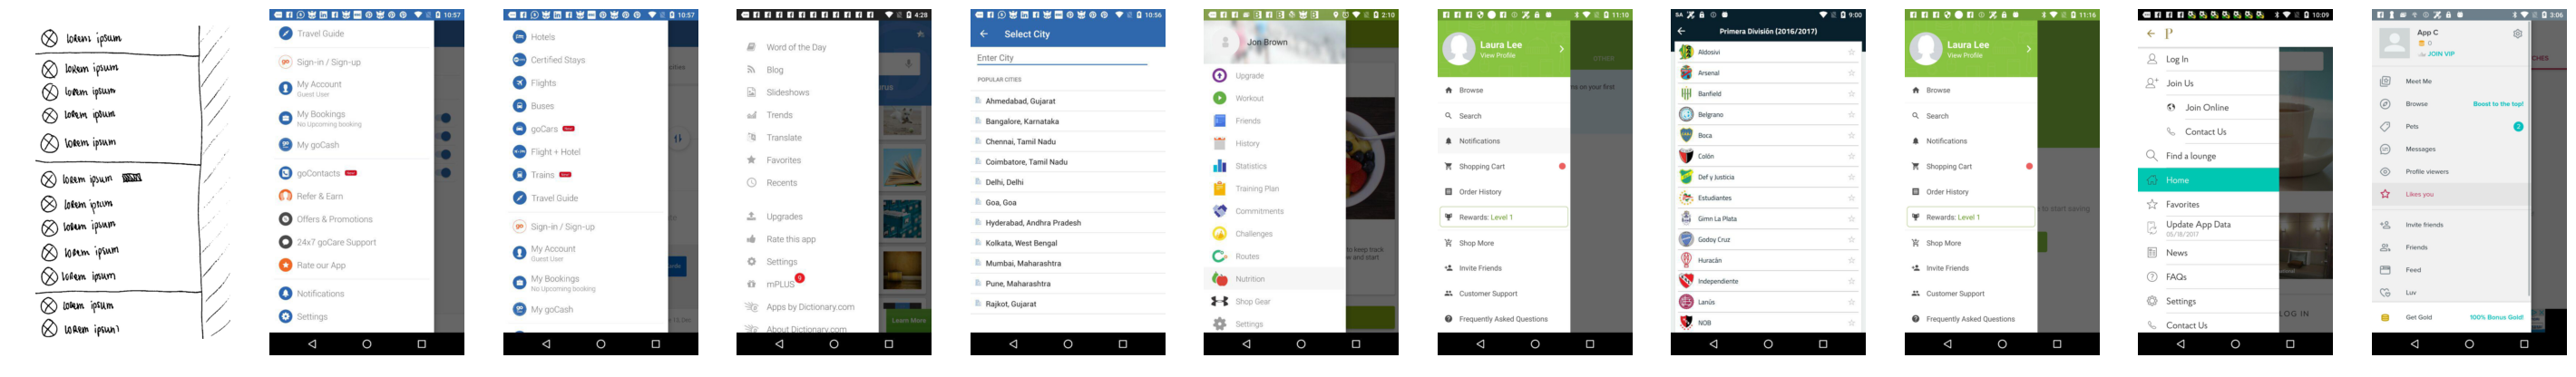

In [7]:
print_query_results(tops[15], figsize=(50, 50))
plt.show()

## Querying for Similar Screenshots
To find similar screenshots, simply pass the screenshot vectors twice to search for similar screenshots

In [8]:
tops = search_best_from_vecs(load_remote_npy(real_npy_path), load_remote_npy(real_npy_path))

In [9]:
def print_screenshot_query_results(res, figsize=(35, 35)):
  plt.figure(figsize=figsize)
  plt.subplot(1, 11, 1)
  draw_real_image(res[0], figsize is not None)
  for idx, img_id in enumerate(res[1][:10]):
    plt.subplot(1, 11, idx + 2)
    draw_real_image(img_id, figsize is not None)
  print("Query: ", res[0])
  print("Results: ", res[1][:5])

('Query: ', 4134)
('Results: ', array([4134, 4135, 21710, 21727, 21730], dtype=object))


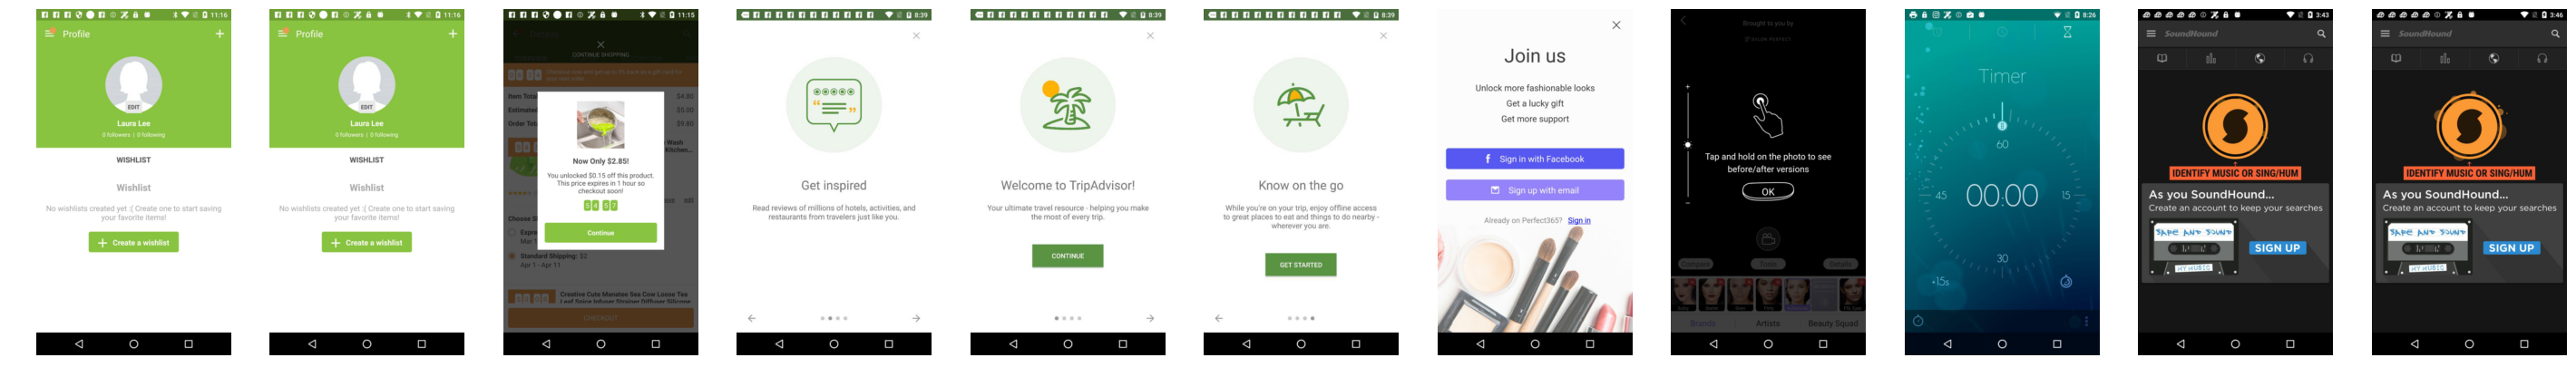

In [10]:
print_screenshot_query_results(tops[13], figsize=(50, 50))
plt.show()

## Querying for UI Flows
Before we start, define another function to print out results for flows

In [11]:
def print_multi_query_results(res, figsize=(35, 35)):
  plt.figure(figsize=figsize)
  plt.subplot(3, 2, 1)
  draw_actual_sketch(str(res[0][0]) + '_4', figsize is not None)
  plt.subplot(3, 2, 2)
  draw_actual_sketch(str(res[0][1]) + '_4', figsize is not None)
  for idx, img_id in enumerate(res[1][:2]):
    plt.subplot(3, 2, idx * 2 + 3)
    draw_real_image(img_id[0], figsize is not None)
    plt.subplot(3, 2, idx * 2 + 4)
    draw_real_image(img_id[1], figsize is not None)
  plt.show() 
  print("Query: ", res[0])
  print("Results: ", res[1][:5])


First, compute a reverse lookup dictionary between the next screens of UIs.

In [12]:
import csv

url = 'https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/ui_details.csv'

res = requests.get(url)
f = open('tmp.csv', 'wb')
f.write(res.content)
f.close()


ui_traces = {}
from collections import defaultdict
trace_dict = defaultdict(list)

with open('tmp.csv', 'rU') as c: 
  reader = csv.reader(c)
  skip = False
  for row in reader:
    if not skip:
      skip = True
      continue
    trace_dict[row[1]+row[2]].append((int(row[3]), int(row[0])))

for _, v in trace_dict.iteritems():
  s_list = sorted(v, key=lambda x: x[0])
  for idx, i in enumerate(s_list[1:]):
    ui_traces[s_list[idx][1]] = i[1]
  

Then, augment the vectors 

In [13]:
def augment_vecs(vecs, next_dict):
  new_vecs = []
  logits = {v[1]: v[0] for v in vecs}
  for v in vecs:
    if v[1] in next_dict and next_dict[v[1]] in logits:
      new_logits = np.concatenate([v[0], logits[next_dict[v[1]]]], axis=-1)
      new_vecs.append(np.array([new_logits, [v[1], next_dict[v[1]]]]))
  return np.array(new_vecs)


In [14]:
tops = search_best_from_vecs(augment_vecs(load_remote_npy(sketch_npy_path), ui_traces), augment_vecs(load_remote_npy(real_npy_path), ui_traces))

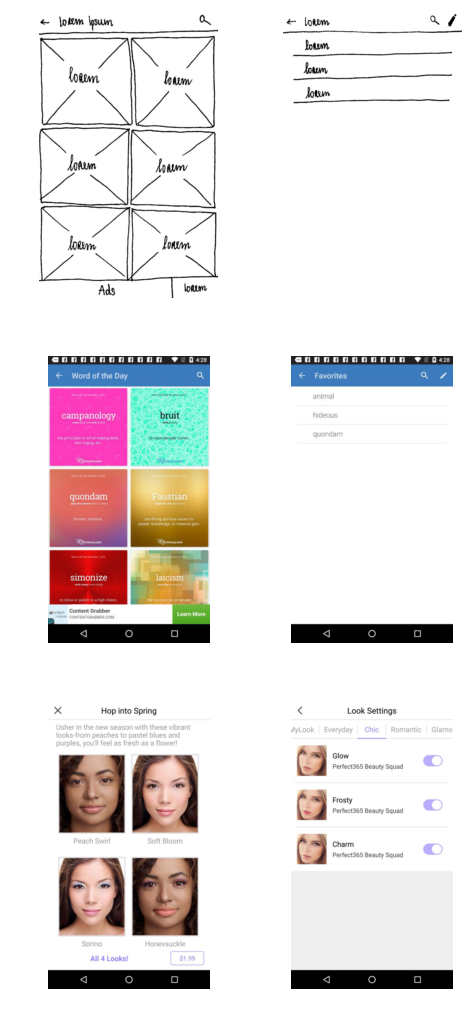

('Query: ', [29786, 29767])
('Results: ', array([list([29786, 29767]), list([54847, 54831]), list([4136, 4133]),
       list([41943, 41938]), list([1241, 1245])], dtype=object))


In [15]:
print_multi_query_results(tops[2], figsize=(8, 18))
plt.show()

## Querying for Segments
Simply load the segments query vectors instead of the normal query vectors

In [16]:
def print_seg_query_results(res, figsize=(35, 35)):
  plt.figure(figsize=figsize)
  plt.subplot(1, 4, 1)
  draw_actual_sketch(str(res[0]) + '_4', figsize is not None, crop=True)
  # draw_real_image(res[0], figsize is not None)
  for idx, img_id in enumerate(res[1][:3]):
    plt.subplot(1, 4, idx + 2)
    draw_real_image(img_id, figsize is not None)
  print("Query: ", res[0])
  print("Results: ", res[1][:5])

In [17]:
tops = search_best_from_vecs(load_remote_npy(sketch_seg_npy_path)[2], load_remote_npy(real_seg_npy_path)[2])

('Query: ', 53739)
('Results: ', array([53739, 21721, 21718, 54844, 53745], dtype=object))


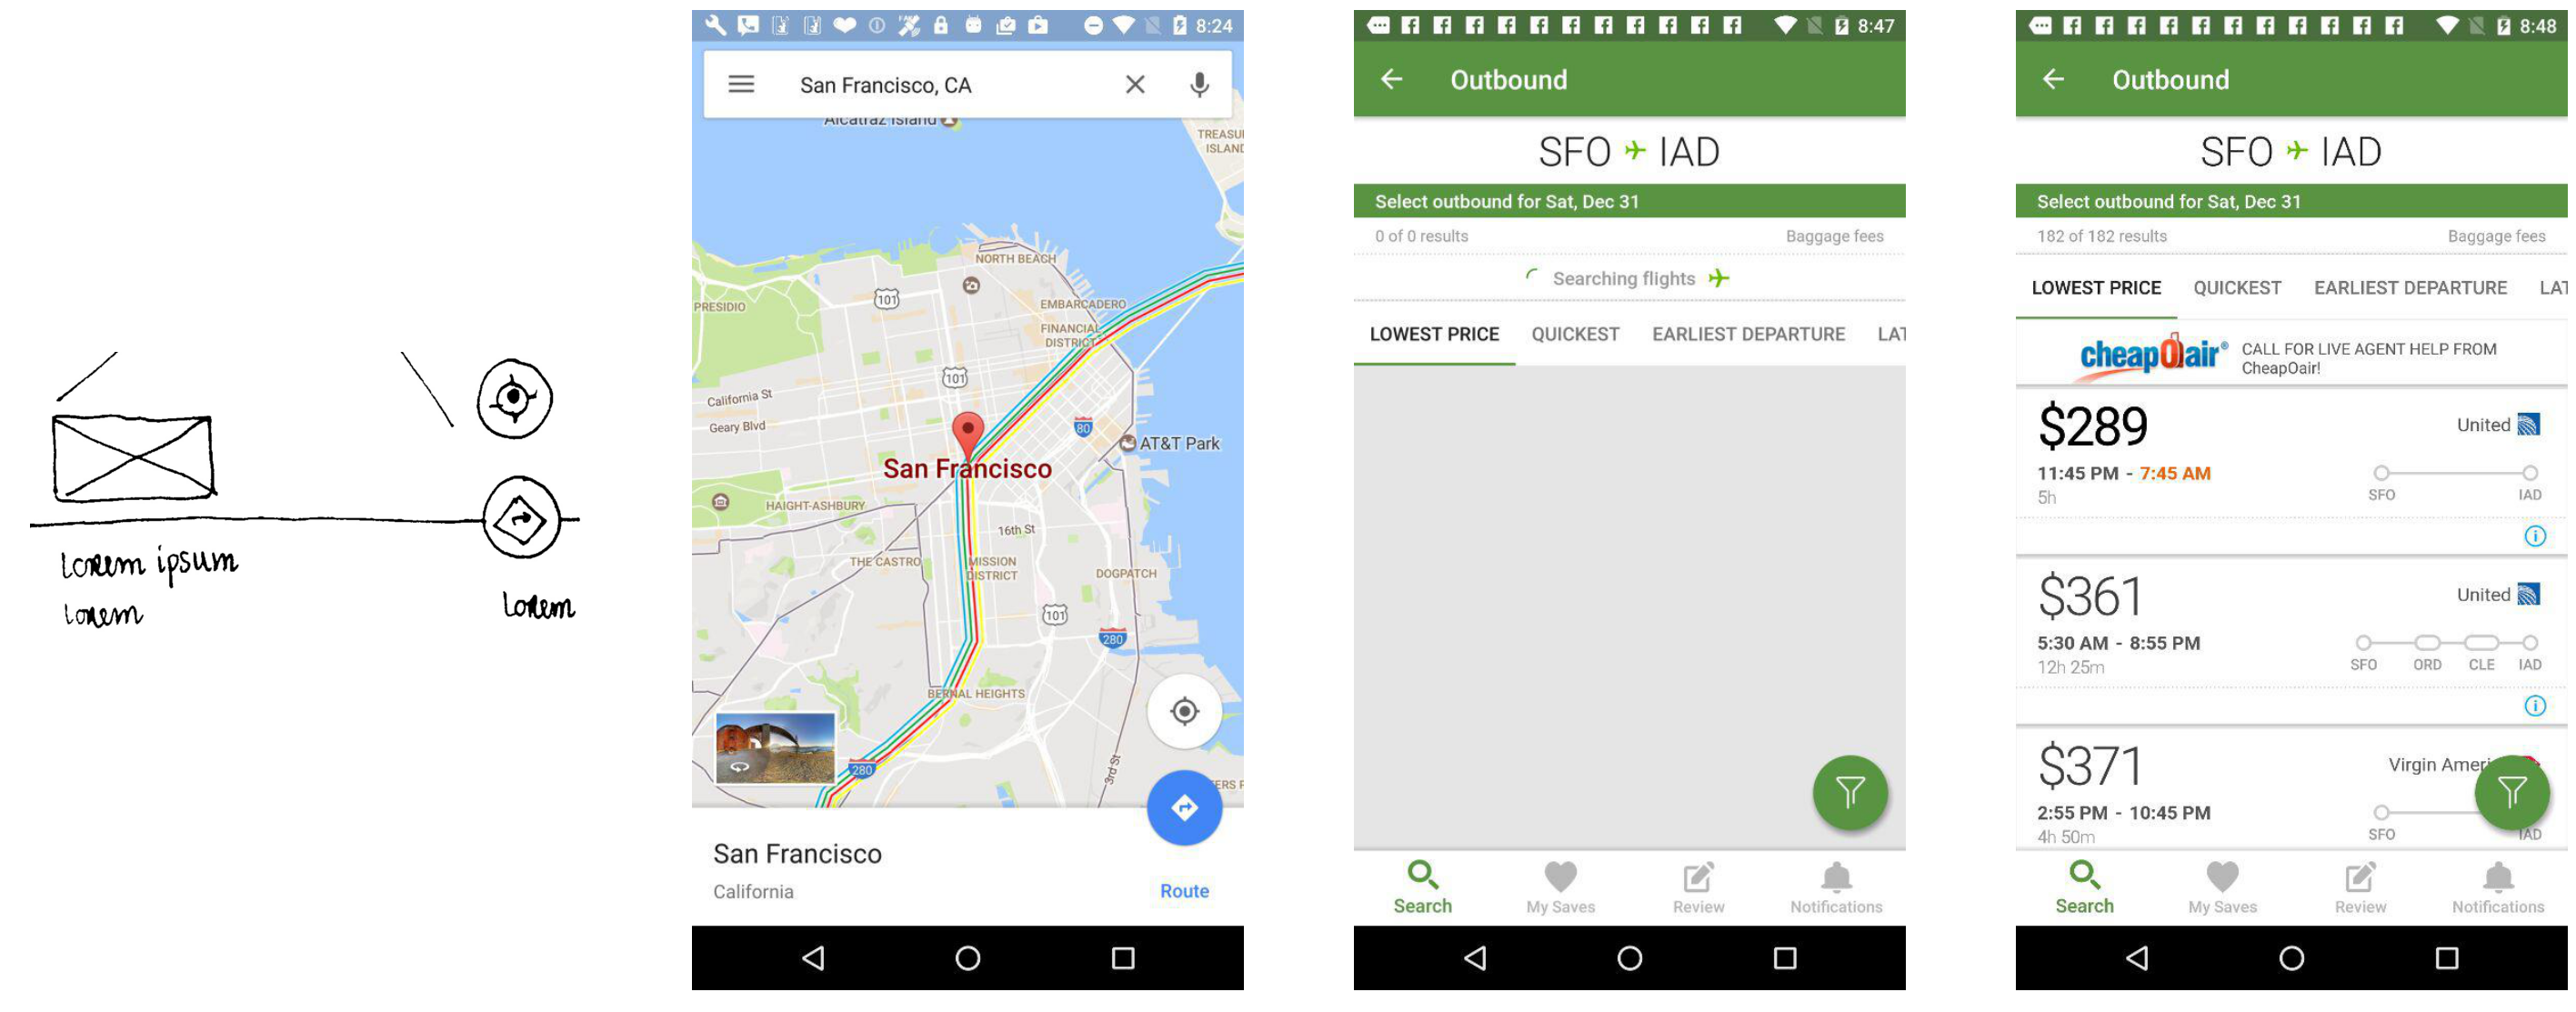

In [18]:
print_seg_query_results(tops[26], figsize=(50, 50))
plt.show()